In [1]:
import pandas as pd
import numpy as np
import pickle, time, math
import os, json, csv
from pandas.io.json import json_normalize

In [2]:
def load_data(csv_path='train.csv',JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']):
    
    data=pd.read_csv(csv_path,
        converters={column: json.loads for column in JSON_COLUMNS}, 
        dtype={'fullVisitorId': 'str'},  # Important!!
        #nrows=nrows
                    ) 
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(data[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        data = data.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {csv_path}. Shape: {data.shape}")
    return data

In [3]:
data1=load_data()
data1['isTrain']=True
data2=load_data(csv_path='test.csv')
data2['isTrain']=False
data=data1.append(data2).reset_index(drop=True)
data=data.rename({'trafficSource_adwordsClickInfo.adNetworkType':'trafficSource_adwordsClickInfoadNetworkType',
'trafficSource_adwordsClickInfo.gclId':'trafficSource_adwordsClickInfo_gclId',
'trafficSource_adwordsClickInfo.page':'trafficSource_adwordsClickInfo_page',
'trafficSource_adwordsClickInfo.slot':'trafficSource_adwordsClickInfo_slot'},axis='columns')
print(data.shape)

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)


C:\Users\h_agu\Desktop\machine_learning\Miniconda3\envs\tensorflow-gpu3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(1708337, 56)


In [4]:
COLUMNS_WITH_ONE_VAL=[]
for col in data.columns:
    n=data[col].nunique()
    nv=data[col].unique()
    #print(col,n)
    if n== 1:
        COLUMNS_WITH_ONE_VAL.append(col)
        #print(col,nv,n)
    if n==2:
        if 'not available in demo dataset' in nv:
            COLUMNS_WITH_ONE_VAL.append(col)
            #print(col,nv,n)
#data=data.drop(COLUMNS_WITH_ONE_VAL,axis=1)
c=[col for col in COLUMNS_WITH_ONE_VAL if col not in ['trafficSource_isTrueDirect','trafficSource_campaignCode','totals_visits','totals_newVisits','totals_bounces']]
COLUMNS_WITH_ONE_VAL=c

C:\Users\h_agu\Desktop\machine_learning\Miniconda3\envs\tensorflow-gpu3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.


In [5]:
print(data.shape)
data=data.drop(COLUMNS_WITH_ONE_VAL,axis=1)
print(data.shape)

(1708337, 56)
(1708337, 37)


In [6]:
col_num=['totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews']
col_app=[]
for col in col_num:
    data[col +"_imputed"]=pd.isnull(data[col]).astype(np.bool)
    #data[col]=data[col].astype(np.int)
    col_app.append(col +"_imputed")
    data[col].fillna(0,inplace=True)
    
drop_imputed=[]
for col in col_app:
    n=(data[col][data[col]==1]).shape[0]
    if n == 0:
        drop_imputed.append(col)
data=data.drop(drop_imputed,axis=1)  
data['totals_transactionRevenue'].fillna(0,inplace=True)
data['totals_transactionRevenue']=data['totals_transactionRevenue'].astype(np.float)
data.totals_bounces=data.totals_bounces.astype(np.bool)
data.totals_bounces.fillna(False,inplace=True)
data.totals_newVisits=data.totals_newVisits.astype(np.bool)
data.totals_newVisits.fillna(False,inplace=True)

In [7]:
#data[data['totals_bounces']=='1']['totals_bounces']=1
idx=[]
keyword=[]
for _idx,r in zip(data[data.trafficSource_adContent.isnull()==False].index,data[data.trafficSource_adContent.isnull()==False]['trafficSource_adContent']):
    #print(r)
    if '{' in r:
        idx.append(_idx)
        keyword.append(r.split(':')[1].replace('}',''))
df=pd.DataFrame(dict({'trafficSource_adContent_keyword':keyword}),index=idx)
data['trafficSource_adContent_keyword']=df
data.loc[df.index,'trafficSource_adContent']='keyword'

category_columns=['trafficSource_adContent_keyword','trafficSource_adContent','trafficSource_adwordsClickInfoadNetworkType'
                    ,'trafficSource_adwordsClickInfo_gclId','trafficSource_adwordsClickInfo_page'
                    ,'trafficSource_adwordsClickInfo_slot','trafficSource_campaign'
                    ,'trafficSource_campaignCode','trafficSource_isTrueDirect','trafficSource_keyword','trafficSource_medium'
                    ,'trafficSource_referralPath','trafficSource_source','device_browser','device_deviceCategory'
                    ,'device_operatingSystem','geoNetwork_city'
                    ,'geoNetwork_continent'
                    ,'geoNetwork_country'
                    ,'geoNetwork_metro'
                    ,'geoNetwork_networkDomain'
                    ,'geoNetwork_region'
                    ,'geoNetwork_subContinent'
                 ]

column_bool=['trafficSource_isTrueDirect','totals_bounces','totals_newVisits']

column_datetime=['date','visitStartTime']


In [8]:
category_columns=['trafficSource_adContent_keyword','trafficSource_adContent','trafficSource_adwordsClickInfoadNetworkType'
                    ,'trafficSource_adwordsClickInfo_gclId','trafficSource_adwordsClickInfo_page'
                    ,'trafficSource_adwordsClickInfo_slot','trafficSource_campaign'
                    ,'trafficSource_campaignCode','trafficSource_isTrueDirect','trafficSource_keyword','trafficSource_medium'
                    ,'trafficSource_referralPath','trafficSource_source','device_browser','device_deviceCategory'
                    ,'device_operatingSystem','geoNetwork_city'
                    ,'geoNetwork_continent'
                    ,'geoNetwork_country'
                    ,'geoNetwork_metro'
                    ,'geoNetwork_networkDomain'
                    ,'geoNetwork_region'
                    ,'geoNetwork_subContinent'
                    ,'channelGrouping'
                 ]

column_bool=['trafficSource_isTrueDirect','totals_bounces','totals_newVisits','totals_bounces_imputed',
 'totals_newVisits_imputed',
 'totals_pageviews_imputed']

column_datetime=['date','visitStartTime']

for col in category_columns:
    #data[col]=data[col].astype(np.object)
    data[col].fillna('?',inplace=True)
    data[col]=data[col].astype('category')
   
for col in column_bool:
    data[col]=data[col].astype(np.object)
    data[col].fillna(False,inplace=True)
    data[col]=data[col].astype(np.bool)

In [9]:
integer_columns=['totals_hits','totals_pageviews','totals_visits']

for col in integer_columns:
    data[col].fillna(0,inplace=True)
    data[col]=data[col].astype(np.int)

In [10]:
data['visitStartTime']=pd.to_datetime(data['visitStartTime'],unit='s')
data['date']=pd.to_datetime(data['date'])

data['visitStartTime_dayofweek']=data['visitStartTime'].dt.dayofweek
data['visitStartTime_dayofyear']=data['visitStartTime'].dt.dayofyear
data['visitStartTime_hourofday']=data['visitStartTime'].dt.hour
data['visitStartTime_dayofmonth']=data['visitStartTime'].dt.day
data['visitStartTime_month']=data['visitStartTime'].dt.month
data['visitStartTime_year']=data['visitStartTime'].dt.year
#data['visitStartTime_weekofmonth']

data['date_day']=data['date'].dt.day
data['date_month']=data['date'].dt.month
data['date_year']=data['date'].dt.year
data['date_dayofyear']=data['date'].dt.dayofyear
data['date_dayofweek']=data['date'].dt.dayofweek

times_columns=['visitStartTime_dayofweek','visitStartTime_dayofyear','visitStartTime_hourofday'
              ,'visitStartTime_dayofmonth','visitStartTime_month','visitStartTime_year'
              ,'date_day','date_month','date_year','date_dayofyear','date_dayofweek']

for col in times_columns:
    data[col]=data[col].astype('category')

In [11]:
times_columns=['visitStartTime_dayofweek','visitStartTime_dayofyear','visitStartTime_hourofday'
              ,'visitStartTime_dayofmonth','visitStartTime_month','visitStartTime_year'
              ,'date_day','date_month','date_year','date_dayofyear','date_dayofweek']

for col in times_columns:
    data[col]=data[col].astype('category')

In [12]:
with open('train_data.pickle','wb') as f:
    pickle.dump(data,f)

In [14]:
from catboost import CatBoostClassifier,Pool
from sklearn.model_selection import StratifiedKFold, train_test_split,GroupKFold

In [15]:
with open('train_data.pickle','rb') as f:
    data=pickle.load(f)

In [13]:
data['totals_hits_views_ratio']=data['totals_hits']/data['totals_pageviews']

In [14]:
def binning_pageviews(data):
    bins=[5,10,30,50,100]
    column_name='totals_pageviews'
    #bin_labels=['visit_1to5','visit_5to10','visit_10to30','visit_30to50','visit_50to100','visit_100to150']
    #_=[for _bin in bins]
    #print(len(bins),len(bin_labels))
    bin_labels=[]
    for i,_bin in enumerate(bins):
        if i == 0 :
            bin_labels.append(column_name+'_to_'+str(_bin))
            data[bin_labels[i]]=data[column_name]<=_bin
            data[bin_labels[i]].astype(np.bool)
        else :
            bin_labels.append(column_name+'_between_'+str(bins[i-1])+'_'+str(_bin))
            data[bin_labels[i]]=(data[column_name]<=_bin) & (data[column_name]>bins[i-1])
            data[bin_labels[i]].astype(np.bool)
        if len(bins)-1 == i:
            bin_labels.append(column_name+'_greater_'+str(_bin))
            data[bin_labels[i+1]]=(data[column_name]>_bin)
            data[bin_labels[i+1]].astype(np.bool)
    return data

In [15]:
data=binning_pageviews(data)

In [16]:
with open('train_data.pickle','wb') as f:
    pickle.dump(data,f)

In [17]:
with open('train_data.pickle','rb') as f:
    data=pickle.load(f)

In [21]:
print(data.shape,data_test.shape)

(903653, 59) (804684, 59)


In [66]:
_x=data.groupby('fullVisitorId').agg({'visitId':'count'}).reset_index().rename(columns={'visitId':'countId'})

In [80]:
multi_id=(data[data.fullVisitorId.isin(fullVisitorids.fullVisitorId)].sort_values(['fullVisitorId']))[['fullVisitorId','visitStartTime','totals_hits','totals_pageviews','isTrain','totals_newVisits','totals_transactionRevenue']]

In [81]:
multi_id2=multi_id[multi_id.fullVisitorId.isin(multi_id[multi_id.totals_transactionRevenue>0].fullVisitorId)]

In [18]:
data_test=data[data.isTrain==False]
data=data[data.isTrain==True]

In [19]:
x=data.copy()
if 'totals_transactionRevenue' in data.columns:
    y=x.pop('totals_transactionRevenue').to_frame()

In [20]:
#x=x.drop(['date','visitStartTime','fullVisitorId','sessionId','isTrain','visitId'],axis=1)
x=x.drop(['date','visitStartTime','sessionId','isTrain','visitId'],axis=1)
x['fullVisitorId']=x['fullVisitorId'].astype('category')

In [21]:
def columns_index(x):
    features=x.columns.tolist()
    category_features=[]
    category_features_idx=[]
    for col in features:
        if str(x[col].dtype)=='category':
            #print(col,np.object)
            category_features.append(col)
            category_features_idx.append(features.index(col))
        if x[col].dtype==np.bool:
            #print(col,np.bool)
            category_features.append(col)
            category_features_idx.append(features.index(col))
    return features, category_features, category_features_idx

In [22]:
features, category_features, category_features_idx=columns_index(x)

In [23]:
def fit(params=None, dtrain=None, dtest=None, n_estimators=None, seed=0, run_time=None, run_cv_id=0, eval_no=0, verbose=False):
    global metric,column_names
    #print(run_cv_id, eval_no)
    path="./cv_run/"+str(run_time)
    if not os.path.isdir(path):
        os.mkdir(path)
    fpath=path+"/"+str(eval_no)+"."+str(run_cv_id)
    if not os.path.isdir(fpath):
        os.mkdir(fpath)    
    params.update({"iterations": n_estimators})
    params.update({"eval_metric": metric})
    params.update({"logging_level": 'Verbose'})
    params.update({"metric_period": 100})
    params.update({"random_seed": seed})
    params.update({"leaf_estimation_method": "Newton"})
    #params.update({"leaf_estimation_iterations" : 10})
    params.update({"rsm" : 1})
    params.update({"thread_count" : 8})
    params.update({"fold_len_multiplier": 2})
    #params.update({"max_ctr_complexity":5})
    params.update({"train_dir": fpath})
    params.update({"calc_feature_importance" : True})
    params.update({'od_type':'Iter'})
    params.update({'od_wait':30})
    params.update({'od_pval':1e-3})
    
    bst = CatBoostClassifier(**params)
    bst.fit(dtrain, eval_set=dtest, use_best_model=True)
    with open(fpath + "/test_error.tsv", "r") as f:
        reader=np.array(list(csv.reader(f,delimiter='\t'))).squeeze()
    header=reader[0]
    feature=dict()
    for col, val in zip(features,bst.__dict__['_feature_importance']):
        feature.update({col:val})
    #pd.to_pickle(bst.__dict__['_feature_importance'],path+"/feature_importance."+str(eval_no)+"."+str(run_cv_id))
    pd.to_pickle(feature,path+"/feature_importance."+str(eval_no)+"."+str(run_cv_id))
    idx=(header==metric).argmax()
    #print('idx',idx, metric)
    results=(reader[1:reader.shape[0],idx]).astype(np.float)
    
    if metric=='AUC' or metric=='Accuracy':
        #print("metric",metric)
        results=1-results
    #print('results',results)
    return bst, results

In [24]:
params=dict({'bagging_temperature': 0.087,
 'border_count': 32,
 'depth': 4,
 'fold_len_multiplier': 2,
 'l2_leaf_reg': 6.5,
 'leaf_estimation_iterations': 3,
 'leaf_estimation_method': 'Gradient',
 'learning_rate': 0.01,
 'max_ctr_complexity': 4.0,
 'one_hot_max_size': 225,
 'random_strength': 5,
 'rsm': 1,
 #'iterations': 1000,
 #'eval_metric': 'Accuracy',
 'logging_level': 'Verbose',
 'metric_period': 100,
 #'random_seed': 0,
 'thread_count': 8,
 'train_dir': './cv_run',
 'calc_feature_importance': True,
 'od_type': 'Iter',
 'od_wait': 30,
 'od_pval':1e-3})

In [ ]:
from sklearn.model_selection import GroupKFold

In [10]:
#xtrain,xtest,ytrain,ytest=train_test_split(x, y, test_size=0.1, random_state=42, shuffle=True, stratify=y)
_y=y.copy()
_y.loc[(_y['totals_transactionRevenue']>0),'totals_transactionRevenue']=1
_y.loc[(_y['totals_transactionRevenue']==0),'totals_transactionRevenue']=0

In [11]:
xtrain1,xtest1,ytrain1,ytest1=train_test_split(x, _y, test_size=0.4, random_state=42, shuffle=True, stratify=_y)

## binary prediction

In [14]:
metric='AUC'
arg=params
run_time='blah'
#(datetime.now()).strftime('%Y%m%d%H%M')
trainP=Pool(xtrain1,ytrain1,cat_features=category_features_idx)
testP=Pool(xtest1,ytest1,cat_features=category_features_idx)
bst,res=fit(params=arg,dtrain=trainP,dtest=testP,n_estimators=20,seed=13,run_time=run_time)

0:	learn: 0.9715926	test: 0.9731978	best: 0.9731978 (0)	total: 1.75s	remaining: 33.2s

bestTest = 0.9815227539
bestIteration = 18

Shrink model to first 19 iterations.


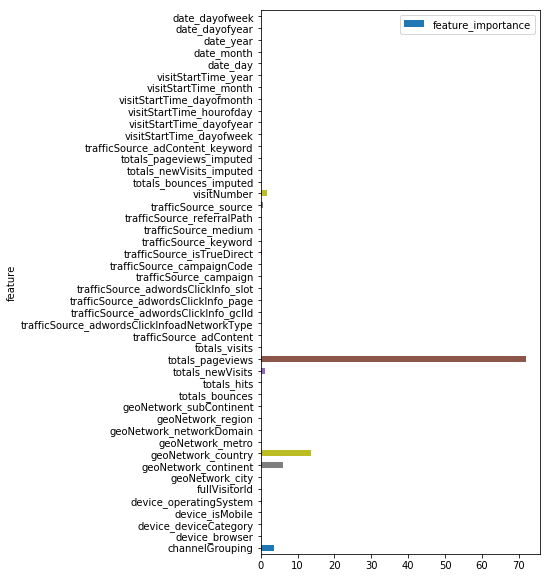

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
feature_importance=pd.DataFrame({'feature':x.columns.tolist()[0:len(x.columns)],'feature_importance':bst.feature_importances_})
feature_importance.plot.barh(x='feature',y='feature_importance',figsize=(5,10))
plt.show()

## add total hit/view ratio

In [15]:
x['totals_hits_views_ratio']=data['totals_hits']/data['totals_pageviews']

In [16]:
xtrain2,xtest2,ytrain2,ytest2=train_test_split(x, _y, test_size=0.4, random_state=41, shuffle=True, stratify=_y)

In [17]:
features, category_features, category_features_idx=columns_index(x)

In [18]:
metric='AUC'
arg=params
run_time='blah'
#(datetime.now()).strftime('%Y%m%d%H%M')
trainP=None
testP=None
trainP=Pool(xtrain2,ytrain2,cat_features=category_features_idx)
testP=Pool(xtest2,ytest2,cat_features=category_features_idx)
bst2,res=fit(params=arg,dtrain=trainP,dtest=testP,n_estimators=20,seed=14,run_time=run_time)

0:	learn: 0.9772113	test: 0.9766255	best: 0.9766255 (0)	total: 1.67s	remaining: 31.8s

bestTest = 0.9812341397
bestIteration = 18

Shrink model to first 19 iterations.


In [22]:
with open('./model/model.2.20181016.pickle','wb') as f:
    pickle.dump(bst2,f)

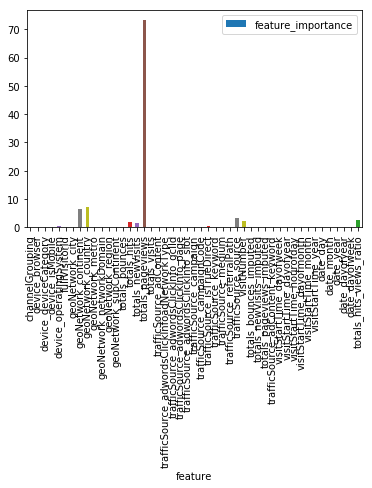

In [23]:
feature_importance=pd.DataFrame({'feature':x.columns.tolist(),'feature_importance':bst2.feature_importances_})
feature_importance.plot.barh(x='feature',y='feature_importance',figsize=(5,10))
plt.show()

In [24]:
acc = bst2.eval_metrics(testP,['Accuracy','AUC'])

In [29]:
_y[_y.totals_transactionRevenue==0].count()[0]/_y.shape[0]#_y[_y.totals_transactionRevenue>0].count()[0]

0.9872572768529513

## binning total pageview

In [19]:
def binning_pageviews(data):
    bins=[5,10,30,50,100]
    column_name='totals_pageviews'
    #bin_labels=['visit_1to5','visit_5to10','visit_10to30','visit_30to50','visit_50to100','visit_100to150']
    #_=[for _bin in bins]
    #print(len(bins),len(bin_labels))
    bin_labels=[]
    for i,_bin in enumerate(bins):
        if i == 0 :
            bin_labels.append(column_name+'_to_'+str(_bin))
            data[bin_labels[i]]=data[column_name]<=_bin
            data[bin_labels[i]].astype(np.bool)
        else :
            bin_labels.append(column_name+'_between_'+str(bins[i-1])+'_'+str(_bin))
            data[bin_labels[i]]=(data[column_name]<=_bin) & (data[column_name]>bins[i-1])
            data[bin_labels[i]].astype(np.bool)
        if len(bins)-1 == i:
            bin_labels.append(column_name+'_greater_'+str(_bin))
            data[bin_labels[i+1]]=(data[column_name]>_bin)
            data[bin_labels[i+1]].astype(np.bool)
    return data


In [30]:
x=binning_pageviews(x)
x=x.drop(['totals_pageviews'],axis=1)
xtrain3,xtest3,ytrain3,ytest3=train_test_split(x, _y, test_size=0.4, random_state=41, shuffle=True, stratify=_y)
features, category_features, category_features_idx=columns_index(x)

KeyError: 'totals_pageviews'

In [31]:
metric='AUC'
arg=params
run_time='blah'
#(datetime.now()).strftime('%Y%m%d%H%M')
trainP3=Pool(xtrain3,ytrain3,cat_features=category_features_idx)
testP3=Pool(xtest3,ytest3,cat_features=category_features_idx)
bst3,res=fit(params=arg,dtrain=trainP3,dtest=testP3,n_estimators=2101,seed=13,run_time=run_time)

0:	learn: 0.9737036	test: 0.9733181	best: 0.9733181 (0)	total: 1.51s	remaining: 52m 43s
100:	learn: 0.9819361	test: 0.9815498	best: 0.9815498 (100)	total: 1m 49s	remaining: 36m 8s
200:	learn: 0.9831222	test: 0.9827335	best: 0.9827335 (200)	total: 3m 35s	remaining: 33m 57s
300:	learn: 0.9846326	test: 0.9845201	best: 0.9845201 (300)	total: 5m 40s	remaining: 33m 59s
400:	learn: 0.9861179	test: 0.9860580	best: 0.9860580 (400)	total: 7m 40s	remaining: 32m 33s
500:	learn: 0.9866163	test: 0.9866584	best: 0.9866584 (500)	total: 9m 18s	remaining: 29m 45s
600:	learn: 0.9871248	test: 0.9872581	best: 0.9872581 (600)	total: 10m 51s	remaining: 27m 5s
700:	learn: 0.9872754	test: 0.9874263	best: 0.9874263 (700)	total: 12m 30s	remaining: 24m 58s
800:	learn: 0.9873172	test: 0.9874733	best: 0.9874733 (791)	total: 14m 5s	remaining: 22m 52s
900:	learn: 0.9873359	test: 0.9874935	best: 0.9874935 (894)	total: 15m 31s	remaining: 20m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.987497

In [36]:
bst3.save_model('./model/model.3.20181018.cbm')

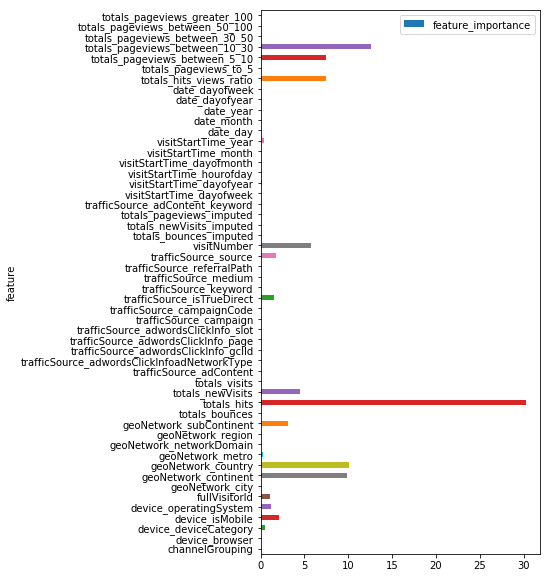

In [22]:
#fig = plt.figure()
feature_importance=pd.DataFrame({'feature':features,'feature_importance':bst3.feature_importances_})
feature_importance.plot.barh(x='feature',y='feature_importance',figsize=(5,10))
plt.show()

In [18]:
metric='AUC'
arg=params
run_time='blah'
#(datetime.now()).strftime('%Y%m%d%H%M')
trainP3=Pool(xtrain3,ytrain3,cat_features=category_features_idx)
testP3=Pool(xtest3,ytest3,cat_features=category_features_idx)
bst3,res=fit(params=arg,dtrain=trainP3,dtest=testP3,n_estimators=2000,seed=13,run_time=run_time)

0:	learn: 0.9770795	test: 0.9765546	best: 0.9765546 (0)	total: 1.16s	remaining: 38m 44s
100:	learn: 0.9802569	test: 0.9798978	best: 0.9800129 (95)	total: 1m 27s	remaining: 27m 21s
200:	learn: 0.9812651	test: 0.9808919	best: 0.9808919 (200)	total: 2m 56s	remaining: 26m 15s
300:	learn: 0.9826205	test: 0.9824050	best: 0.9824212 (288)	total: 4m 25s	remaining: 24m 57s
400:	learn: 0.9838721	test: 0.9838029	best: 0.9838029 (400)	total: 5m 45s	remaining: 22m 57s
500:	learn: 0.9842546	test: 0.9842931	best: 0.9842931 (500)	total: 7m 19s	remaining: 21m 54s
600:	learn: 0.9845853	test: 0.9847117	best: 0.9847117 (599)	total: 9m 1s	remaining: 20m 59s
700:	learn: 0.9846349	test: 0.9847704	best: 0.9847704 (693)	total: 10m 26s	remaining: 19m 20s
800:	learn: 0.9846516	test: 0.9847863	best: 0.9847863 (789)	total: 11m 48s	remaining: 17m 40s
900:	learn: 0.9846734	test: 0.9848083	best: 0.9848083 (880)	total: 13m 13s	remaining: 16m 7s
1000:	learn: 0.9846832	test: 0.9848157	best: 0.9848157 (990)	total: 14m 37s

In [25]:
acc=bst3.eval_metrics(testP3,['Accuracy','AUC'])

In [26]:
print(np.max(acc['Accuracy']),np.argmax(acc['Accuracy']))

0.9882919919659605 807


In [27]:
print(np.max(acc['AUC']),np.argmax(acc['AUC']))

0.9874971936121706 952


In [35]:
prob=bst3.predict_proba(testP3)
yhat=bst3.predict(testP3)

In [45]:
((ytest.totals_transactionRevenue==yhat)&(ytest.totals_transactionRevenue==1)).sum()

25

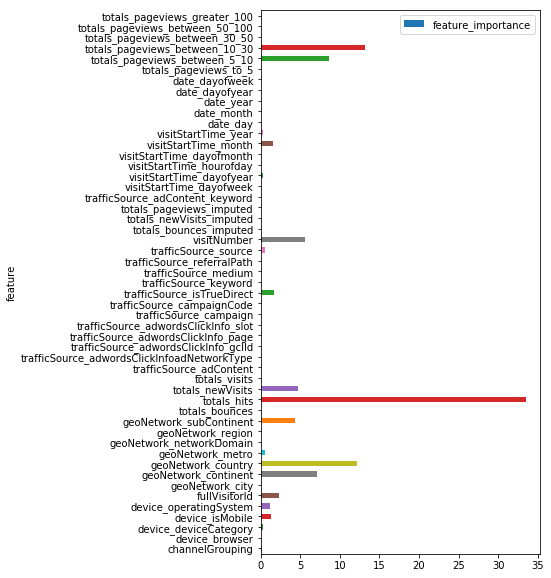

In [19]:
feature_importance=pd.DataFrame({'feature':features,'feature_importance':bst3.feature_importances_})
feature_importance.plot.barh(x='feature',y='feature_importance',figsize=(5,10))
plt.show()

In [48]:
metric='AUC'
arg=params
run_time='blah'
#(datetime.now()).strftime('%Y%m%d%H%M')
trainP3=Pool(xtrain3,ytrain3,cat_features=category_features_idx)
testP3=Pool(xtest3,ytest3,cat_features=category_features_idx)
bst4,res=fit(params=arg,dtrain=trainP3,dtest=testP3,n_estimators=2000,seed=13,run_time=run_time)

0:	learn: 0.9737036	test: 0.9733181	best: 0.9733181 (0)	total: 1.69s	remaining: 56m 26s
100:	learn: 0.9819361	test: 0.9815498	best: 0.9815498 (100)	total: 2m 6s	remaining: 39m 43s
200:	learn: 0.9831222	test: 0.9827335	best: 0.9827335 (200)	total: 4m 13s	remaining: 37m 50s
300:	learn: 0.9846326	test: 0.9845201	best: 0.9845201 (300)	total: 6m 41s	remaining: 37m 44s
400:	learn: 0.9861179	test: 0.9860580	best: 0.9860580 (400)	total: 8m 55s	remaining: 35m 36s
500:	learn: 0.9866163	test: 0.9866584	best: 0.9866584 (500)	total: 11m 4s	remaining: 33m 7s
600:	learn: 0.9871248	test: 0.9872581	best: 0.9872581 (600)	total: 13m 6s	remaining: 30m 29s
700:	learn: 0.9872754	test: 0.9874263	best: 0.9874263 (700)	total: 15m 3s	remaining: 27m 53s
800:	learn: 0.9873172	test: 0.9874733	best: 0.9874733 (791)	total: 16m 32s	remaining: 24m 46s
900:	learn: 0.9873359	test: 0.9874935	best: 0.9874935 (894)	total: 17m 57s	remaining: 21m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.9874971

## binning total hits

In [55]:
def binnning_totalhits(data):
    bins=[5,10,30,50,100]
    column_name='totals_hits'
    #bin_labels=['visit_1to5','visit_5to10','visit_10to30','visit_30to50','visit_50to100','visit_100to150']
    #_=[for _bin in bins]
    #print(len(bins),len(bin_labels))
    bin_labels=[]
    for i,_bin in enumerate(bins):
        if i == 0 :
            bin_labels.append(column_name+'_to_'+str(_bin))
            data[bin_labels[i]]=data[column_name]<=_bin
            data[bin_labels[i]].astype(np.bool)
        else :
            bin_labels.append(column_name+'_between_'+str(bins[i-1])+'_'+str(_bin))
            data[bin_labels[i]]=(data[column_name]<=_bin) & (data[column_name]>bins[i-1])
            data[bin_labels[i]].astype(np.bool)
        if len(bins)-1 == i:
            bin_labels.append(column_name+'_greater_'+str(_bin))
            data[bin_labels[i+1]]=(data[column_name]>_bin)
            data[bin_labels[i+1]].astype(np.bool)
    return data

In [56]:
x2=binnning_totalhits(x)
x2=x2.drop(['totals_hits'],axis=1)
xtrain4,xtest4,ytrain4,ytest4=train_test_split(x2, _y, test_size=0.4, random_state=41, shuffle=True, stratify=_y)
features, category_features, category_features_idx=columns_index(x2)

In [40]:
metric='AUC'
arg=params
run_time='blah'
#(datetime.now()).strftime('%Y%m%d%H%M')
trainP4=Pool(xtrain4,ytrain4,cat_features=category_features_idx)
testP4=Pool(xtest4,ytest4,cat_features=category_features_idx)
bst4,res=fit(params=arg,dtrain=trainP4,dtest=testP4,n_estimators=2000,seed=13,run_time=run_time)

0:	learn: 0.9648148	test: 0.9657530	best: 0.9657530 (0)	total: 1.29s	remaining: 42m 53s
100:	learn: 0.9812105	test: 0.9811530	best: 0.9812225 (99)	total: 1m 37s	remaining: 30m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.9823180976
bestIteration = 108

Shrink model to first 109 iterations.


In [41]:
with open('./model/model.4.20181016.pickle','wb') as f:
    pickle.dump(bst4,f)

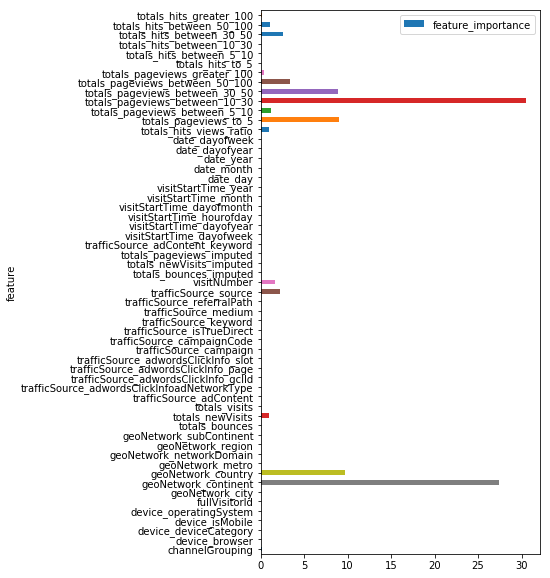

In [42]:
feature_importance=pd.DataFrame({'feature':features,'feature_importance':bst4.feature_importances_})
feature_importance.plot.barh(x='feature',y='feature_importance',figsize=(5,10))
plt.show()

## Regression

In [22]:
from catboost import CatBoostRegressor

In [23]:
def fit_reg(params=None, dtrain=None, dtest=None, n_estimators=None, seed=0, run_time=None, run_cv_id=0, eval_no=0, verbose=False):
    global metric,column_names
    #print(run_cv_id, eval_no)
    path="./cv_run/"+str(run_time)
    if not os.path.isdir(path):
        os.mkdir(path)
    fpath=path+"/"+str(eval_no)+"."+str(run_cv_id)
    if not os.path.isdir(fpath):
        os.mkdir(fpath)    
    params.update({"iterations": n_estimators})
    params.update({"eval_metric": metric})
    params.update({"logging_level": 'Verbose'})
    params.update({"metric_period": 100})
    params.update({"random_seed": seed})
    params.update({"leaf_estimation_method": "Newton"})
    #params.update({"leaf_estimation_iterations" : 10})
    params.update({"rsm" : 1})
    params.update({"thread_count" : 8})
    params.update({"fold_len_multiplier": 2})
    #params.update({"max_ctr_complexity":5})
    params.update({"train_dir": fpath})
    params.update({"calc_feature_importance" : True})
    params.update({'od_type':'Iter'})
    params.update({'od_wait':30})
    params.update({'od_pval':1e-3})
    
    bst = CatBoostRegressor(**params)
    bst.fit(dtrain, eval_set=dtest, use_best_model=True)
    with open(fpath + "/test_error.tsv", "r") as f:
        reader=np.array(list(csv.reader(f,delimiter='\t'))).squeeze()
    header=reader[0]
    feature=dict()
    for col, val in zip(features,bst.__dict__['_feature_importance']):
        feature.update({col:val})
    #pd.to_pickle(bst.__dict__['_feature_importance'],path+"/feature_importance."+str(eval_no)+"."+str(run_cv_id))
    pd.to_pickle(feature,path+"/feature_importance."+str(eval_no)+"."+str(run_cv_id))
    idx=(header==metric).argmax()
    #print('idx',idx, metric)
    results=(reader[1:reader.shape[0],idx]).astype(np.float)
    
    if metric=='AUC' or metric=='Accuracy':
        #print("metric",metric)
        results=1-results
    #print('results',results)
    return bst, results

In [33]:
xtrain4,xtest4,ytrain4,ytest4=train_test_split(x, y, test_size=0.4, random_state=41, shuffle=True, stratify=_y)
features, category_features, category_features_idx=columns_index(x)

In [35]:
metric='RMSE'
arg=params
run_time='blah'
#(datetime.now()).strftime('%Y%m%d%H%M')
trainPlog=None
testPlog=None
trainPlog=Pool(xtrain4,np.log1p(ytrain4.totals_transactionRevenue),cat_features=category_features_idx)
testPlog=Pool(xtest4,np.log1p(ytest4.totals_transactionRevenue),cat_features=category_features_idx)
bsr,res=fit_reg(params=arg,dtrain=trainPlog,dtest=testPlog,n_estimators=2101,seed=33,run_time=run_time)

0:	learn: 2.0082215	test: 2.0161287	best: 2.0161287 (0)	total: 897ms	remaining: 31m 23s
100:	learn: 1.7507961	test: 1.7567967	best: 1.7567967 (100)	total: 1m 24s	remaining: 27m 58s
200:	learn: 1.6883275	test: 1.6934195	best: 1.6934195 (200)	total: 2m 51s	remaining: 27m 3s
300:	learn: 1.6675666	test: 1.6732742	best: 1.6732742 (300)	total: 4m 9s	remaining: 24m 54s
400:	learn: 1.6547593	test: 1.6595483	best: 1.6595483 (400)	total: 5m 15s	remaining: 22m 17s
500:	learn: 1.6474256	test: 1.6528720	best: 1.6528720 (500)	total: 6m 22s	remaining: 20m 20s
600:	learn: 1.6401419	test: 1.6458468	best: 1.6458468 (600)	total: 7m 33s	remaining: 18m 52s
700:	learn: 1.6359250	test: 1.6421038	best: 1.6421038 (699)	total: 8m 41s	remaining: 17m 20s
800:	learn: 1.6321679	test: 1.6388844	best: 1.6388840 (798)	total: 10m 10s	remaining: 16m 30s
900:	learn: 1.6286655	test: 1.6358611	best: 1.6358611 (900)	total: 11m 46s	remaining: 15m 40s
1000:	learn: 1.6258285	test: 1.6335904	best: 1.6335904 (1000)	total: 13m 27

In [37]:
bsr.save_model('./model/model.regression.20181018.cbm')

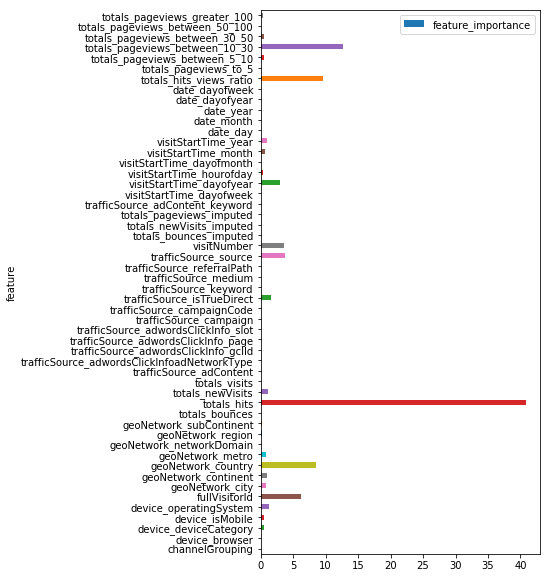

In [53]:
feature_importance=pd.DataFrame({'feature':features,'feature_importance':bsr.feature_importances_})
feature_importance.plot.barh(x='feature',y='feature_importance',figsize=(5,10))
plt.show()

In [58]:
xtrain,xtest,ytrain,ytest=train_test_split(x2, y, test_size=0.4, random_state=41, shuffle=True, stratify=_y)

In [59]:
metric='RMSE'
arg=params
run_time='blah'
#(datetime.now()).strftime('%Y%m%d%H%M')
trainPlog=None
testPlog=None
trainPlog=Pool(xtrain,np.log1p(ytrain.totals_transactionRevenue),cat_features=category_features_idx)
testPlog=Pool(xtest,np.log1p(ytest.totals_transactionRevenue),cat_features=category_features_idx)
bsr2,res=fit_reg(params=arg,dtrain=trainPlog,dtest=testPlog,n_estimators=2000,seed=14,run_time=run_time)

0:	learn: 2.0088684	test: 2.0167175	best: 2.0167175 (0)	total: 1.33s	remaining: 44m 28s
100:	learn: 1.7913413	test: 1.7952784	best: 1.7952784 (100)	total: 1m 6s	remaining: 20m 44s
200:	learn: 1.7336077	test: 1.7378064	best: 1.7378064 (200)	total: 2m 40s	remaining: 23m 52s
300:	learn: 1.7075172	test: 1.7125341	best: 1.7125341 (300)	total: 4m 19s	remaining: 24m 24s
400:	learn: 1.6914964	test: 1.6955320	best: 1.6955320 (400)	total: 5m 56s	remaining: 23m 43s
500:	learn: 1.6826471	test: 1.6867370	best: 1.6867370 (500)	total: 7m 38s	remaining: 22m 50s
600:	learn: 1.6742198	test: 1.6787719	best: 1.6787719 (600)	total: 9m 15s	remaining: 21m 34s
700:	learn: 1.6673415	test: 1.6726804	best: 1.6726804 (700)	total: 10m 53s	remaining: 20m 11s
800:	learn: 1.6628900	test: 1.6684940	best: 1.6684940 (800)	total: 11m 55s	remaining: 17m 50s
900:	learn: 1.6587774	test: 1.6647495	best: 1.6647495 (900)	total: 13m 1s	remaining: 15m 53s
1000:	learn: 1.6551682	test: 1.6614405	best: 1.6614405 (1000)	total: 14m 2

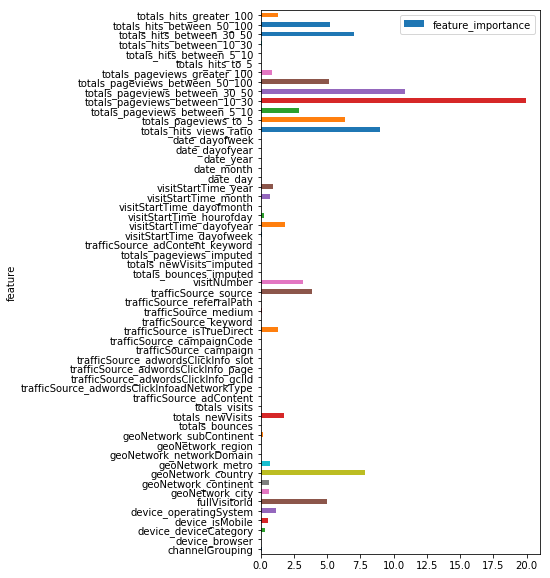

In [60]:
feature_importance=pd.DataFrame({'feature':features,'feature_importance':bsr2.feature_importances_})
feature_importance.plot.barh(x='feature',y='feature_importance',figsize=(5,10))
plt.show()

In [52]:
xtrain,xtest,ytrainR,ytestR=train_test_split(x, y, test_size=0.4, random_state=41, shuffle=True, stratify=_y)

In [53]:
features, category_features, category_features_idx=columns_index(x)

In [59]:
def binarized_y(y):
    _y=y.copy()
    _y.loc[(_y['totals_transactionRevenue']>0),'totals_transactionRevenue']=1
    _y.loc[(_y['totals_transactionRevenue']==0),'totals_transactionRevenue']=0
    return _y

In [60]:
#ytrainB=binarized_y(ytrainR)
ytestB=binarized_y(ytestR)

In [45]:
bsc=CatBoostClassifier()
bsc.load_model(fname='./model/model.3.20181018.cbm',format='cbm')
btf=CatBoostRegressor()
btf.load_model(fname='./model/model.regression.20181018.cbm',format='cbm')

In [124]:
from sklearn.metrics import mean_squared_error

testB=Pool(xtest,ytestB,cat_features=category_features_idx)
testR=Pool(xtest,np.log1p(ytestR),cat_features=category_features_idx)
yhatB=bsc.predict(testB)
yhatR=btf.predict(testR)
yhatR2=yhatB*yhatR
yr=np.array(ytestR.totals_transactionRevenue).reshape(ytestR.shape[0])
print(mean_squared_error(np.log1p(yr),yhatR2))

3.55385137846646


In [137]:
def err1(prob=.98,testB=testB,yhatR=yhatR):
    pred=bsc.predict_proba(testB)
    yhatb=yhatR.copy()
    yhatb[pred[:,0]>prob]=0
    yhatb[pred[:,1]>.55]=17
    #print(yhatR.sum(),yhatb.sum())
    print(mean_squared_error(np.log1p(yr),yhatb))

In [138]:
probas=[.99,.98,.96,.9,.8]
for p in probas:
    err1(p)

2.6868577187954203
2.686933381826648
2.6895435942904498
2.6999446660241304
2.79608513367517


In [110]:
np.mean(np.log1p(ytestR[ytestR!=0]))

C:\Users\h_agu\Desktop\machine_learning\Miniconda3\envs\tensorflow-gpu3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


totals_transactionRevenue    17.865536
dtype: float64

In [112]:
y_=np.zeros(ytestR.shape[0])
y_=y_+17.865536
y_2=y_*yhatB
print(y_2)

[0. 0. 0. ... 0. 0. 0.]


In [115]:
print(mean_squared_error(np.log1p(yr),y_2))

3.7277645149261693


In [26]:
JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

for col in JSON_COLUMNS:
    df1 = pd.DataFrame(data.pop(col).apply(pd.io.json.loads).values.tolist(), index=data.index)
    df1.columns = [ str(col) + '_' + str(Col) for Col in df1.columns]
    data=data.join(df1)

In [5]:
col='trafficSource_adwordsClickInfo'
columns=[]
dat_dict=dict()
for idx,dat in zip(data.index,data[col]):
    #print(idx)
    for key,d in dat.items():
        #a=d.split(':')
        if key not in columns:
            columns.append(key)
            dat_dict.update({key:{'idx':[idx],'val':[d]}})
        else:
            _dict=dat_dict[key]
            _idx=_dict['idx']
            _idx.append(idx)
            _val=_dict['val']
            _val.append(d)

for _col,dat in dat_dict.items():
    df1=pd.DataFrame(dat['val'],index=dat['idx'],columns=[col +'_'+_col.replace("'",'')])
    #print(df1.head())
    data=data.join(df1,how='outer')
    
data=data.drop([col],axis=1)

In [6]:
col_to_drop=['device_browserSize', 'device_browserVersion', 'device_flashVersion', 'device_language'
, 'device_mobileDeviceBranding', 'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName'
, 'device_mobileDeviceModel', 'device_mobileInputSelector', 'geoNetwork_latitude', 'geoNetwork_longitude'
, 'geoNetwork_networkLocation', 'trafficSource_campaignCode', 'socialEngagementType', 'device_operatingSystemVersion'
, 'device_screenColors', 'device_screenResolution', 'trafficSource_adwordsClickInfo_criteriaParameters'
, 'trafficSource_adwordsClickInfo_isVideoAd', 'trafficSource_adwordsClickInfo_targetingCriteria', 'trafficSource_isTrueDirect'
, 'geoNetwork_cityId'
#, 'trafficSource_adwordsClickInfo_targetingCriteria_imputed', 'totals_transactionRevenue_imputed'
]
data=data.drop(col_to_drop,axis=1)

In [7]:
col_num=['totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews']
col_app=[]
for col in col_num:
    data[col +"_imputed"]=pd.isnull(data[col]).astype(np.int)
    data[col]=data[col].astype(np.int)
    col_app.append(col +"_imputed")
    data[col].fillna(0,inplace=True)
    
drop_imputed=[]
for col in col_app:
    n=(data[col][data[col]==1]).shape[0]
    if n == 0:
        drop_imputed.append(col)
data=data.drop(drop_imputed,axis=1)  
data['totals_transactionRevenue'].fillna(0,inplace=True)
data['totals_transactionRevenue']=data['totals_transactionRevenue'].astype(np.float)

In [8]:
data['totals_transactionRevenue'].fillna(0,inplace=True)
data['totals_transactionRevenue']=data['totals_transactionRevenue'].astype(np.float)
#data=data.drop(['totals_visits'],axis=1)

In [9]:
d=data.dtypes.T.apply(pd.Series)
for col, ty in zip(d.index,d.values):
    if ty == 'object' :
        data[col]=data[col].replace(np.nan,'?')

In [10]:
data['totals_transactionRevenue'].fillna(0,inplace=True)

In [ ]:
bins=[5,10,30,50,100]
column_name='totals_hits'
#bin_labels=['visit_1to5','visit_5to10','visit_10to30','visit_30to50','visit_50to100','visit_100to150']
#_=[for _bin in bins]
#print(len(bins),len(bin_labels))
bin_labels=[]
for i,_bin in enumerate(bins):
    if i == 0 :
        bin_labels.append(column_name+'_to_'+str(_bin))
        data[bin_labels[i]]=data[column_name]<=_bin
        data[bin_labels[i]].astype(np.bool)
    else :
        bin_labels.append(column_name+'_between_'+str(bins[i-1])+'_'+str(_bin))
        data[bin_labels[i]]=(data[column_name]<=_bin) & (data[column_name]>bins[i-1])
        data[bin_labels[i]].astype(np.bool)
    if len(bins)-1 == i:
        bin_labels.append(column_name+'_greater_'+str(_bin))
        data[bin_labels[i+1]]=(data[column_name]>_bin)
        data[bin_labels[i+1]].astype(np.bool)

In [11]:
y=data['totals_transactionRevenue']
x=data.copy()
x.drop(['totals_transactionRevenue'],axis=1,inplace=True)
y=pd.DataFrame(y,columns=['totals_transactionRevenue'], index=x.index)

In [13]:
y.to_csv('y.csv',index=False)
x.to_csv('x.csv',index=False)

In [14]:
x=pd.read_csv('x.csv')
y=pd.read_csv('y.csv')

C:\Users\h_agu\Desktop\machine_learning\Miniconda3\envs\tensorflow-gpu3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
def categories_encoder_dictionary(x,y,categories_cols):
    inflection=2
    steepness=0.25
    idx=y[y['totals.transactionRevenue']>0].index
    n_rec=y.shape[0]
    n_rec_event=idx.shape[0]
    n_rec_non_event=n_rec-n_rec_event  
    cat_dict=dict()
    zero=1e-6
    for col in categories_cols:
        g1=x.groupby([col])['date'].count()#],columns=['channelGrouping','instances'])
        g2=x.loc[idx].groupby([col])['date'].count()
        g1=pd.DataFrame(g1)
        g1.columns=['instance']
        g2=pd.DataFrame(g2)
        g2.columns=['events']
        g1=g1.join(g2)
        g1['events']=g1.events.fillna(0)
        g1['non_event']=g1['instance']-g1['events']
        g1['prec_non_event']=(g1['non_event']/n_rec_non_event)*100
        g1['prec_event']=(g1['events']/n_rec_event)*100
        g1['WoE']=np.log(((g1['non_event']+zero)/n_rec_non_event)/((g1['events']+zero)/n_rec_event))
        g1['Info_val']=(g1['prec_non_event']-g1['prec_event'])/100*g1['WoE']
        g1['lambda']=1/(1+np.exp(-(g1['events']-inflection)/steepness))
        g1['Target_Mean']=g1['lambda']*g1['events']/g1['instance']+(1-g1['lambda'])*n_rec_event/n_rec
        cat_dict.update({col:g1})
    return cat_dict

In [40]:
data['visitStartTime']=pd.to_datetime(data['visitStartTime'],unit='s')
data['date']=pd.to_datetime(data['date'])

data['visitStartTime_dayofweek']=data['visitStartTime'].dt.dayofweek
data['visitStartTime_dayofyear']=data['visitStartTime'].dt.dayofyear
data['visitStartTime_hourofday']=data['visitStartTime'].dt.hour
data['visitStartTime_dayofmonth']=data['visitStartTime'].dt.day
data['visitStartTime_month']=data['visitStartTime'].dt.month
data['visitStartTime_year']=data['visitStartTime'].dt.year
#data['visitStartTime_weekofmonth']

data['date_day']=data['date'].dt.day
data['date_month']=data['date'].dt.month
data['date_year']=data['date'].dt.year
data['date_dayofyear']=data['date'].dt.dayofyear
data['date_dayofweek']=data['date'].dt.dayofweek

In [88]:
data['date']=pd.to_datetime(data['date'])
data['date_day']=data['date'].dt.day
data['date_month']=data['date'].dt.month
data['date_year']=data['date'].dt.year
data['date_dayofyear']=data['date'].dt.dayofyear
data['date_dayofweek']=data['date'].dt.dayofweek

In [97]:
data['date']=pd.to_datetime(data['date'])
data['date_quarter']=data['date'].dt.quarter
data['visitStartTime']=pd.to_datetime(data['visitStartTime'])
data['visitStartTime_quarter']=data['visitStartTime'].dt.quarter

In [98]:
data=data.sort_index(axis=1)

In [99]:
data.to_csv('train_data.csv',index=False)

In [2]:
data=pd.read_csv('train_data.csv')

C:\Users\h_agu\Desktop\machine_learning\Miniconda3\envs\tensorflow-gpu3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
if 'geoNetwork_cityId' in data.columns.tolist():
    data=data.drop(['geoNetwork_cityId'],axis=1)

to_drop=['visitStartTime','visitNumber','visitId','totals_hits','totals_pageviews','sessionId','fullVisitorId,'date']

In [4]:
for col in ['totals_bounces_imputed', 'totals_newVisits_imputed','totals_pageviews_imputed']:
    data[col]=data[col].astype(np.bool)

In [5]:
data['totals_hits_views_ratio']=data['totals_hits']/data['totals_pageviews']

In [7]:
data.to_csv('train_data.csv',index=False)

In [10]:
notin=['date','date','sessionId','sessionId']
for col,dtype in zip(data.columns,data.dtypes.T):
    if dtype == np.object:
        print(col,dtype)

channelGrouping object
date object
device_browser object
device_deviceCategory object
device_operatingSystem object
fullVisitorId object
geoNetwork_city object
geoNetwork_continent object
geoNetwork_country object
geoNetwork_metro object
geoNetwork_networkDomain object
geoNetwork_region object
geoNetwork_subContinent object
sessionId object
trafficSource_adContent object
trafficSource_adwordsClickInfo_adNetworkType object
trafficSource_adwordsClickInfo_gclId object
trafficSource_adwordsClickInfo_page object
trafficSource_adwordsClickInfo_slot object
trafficSource_campaign object
trafficSource_keyword object
trafficSource_medium object
trafficSource_referralPath object
trafficSource_source object
visitStartTime object


In [12]:
data['visitStartTime']=pd.to_datetime(data['visitStartTime'])